In [1]:
import h5py
import numpy as np

file_path = '/Users/janniskerl/Downloads/HCF_CP2005_single.mat'

with h5py.File(file_path, 'r') as f:
    # Check the keys (you already saw: 'HCF_CP_single')
    print("Keys:", list(f.keys()))
    
    # Load the dataset
    dataset = f['HCF_CP_single']

    # Convert to NumPy array
    data = np.array(dataset)

    print("Shape of data:", data.shape)


Keys: ['HCF_CP_single']
Shape of data: (8760, 800, 400)


In [2]:
# Rearrange dimensions to: (lat, lon, time)
data = np.transpose(data, (2, 1, 0))  # Now: shape = (400, 800, 8760)
print("Reordered shape:", data.shape)


Reordered shape: (400, 800, 8760)


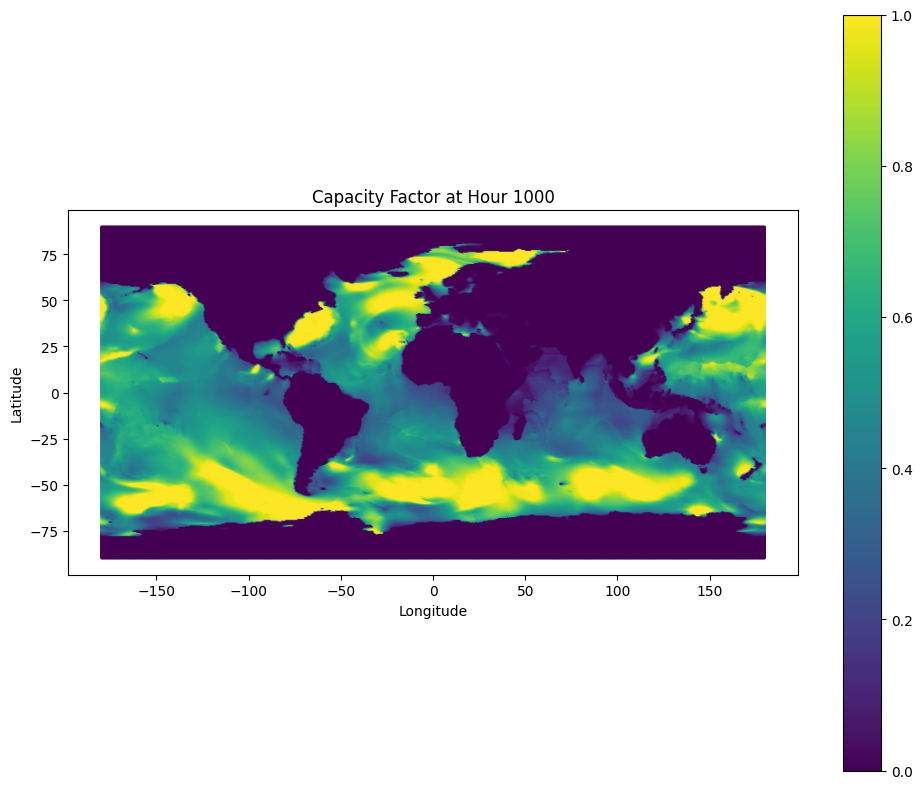

In [3]:
import numpy as np
import pandas as pd
import geopandas as gpd
from shapely.geometry import Point
import matplotlib.pyplot as plt

# -------------------------
# Select a sample hour (0 to 8759)
hour = 1000

# Extract the capacity factor data for that hour (shape: 400 x 800)
cf_hour = data[:, :, hour]

# Grid size and resolution
n_lat, n_lon = data.shape[:2]
resolution = 0.45

# Create row and column indices (1-based as in MATLAB)
rows = np.arange(1, n_lat + 1)
cols = np.arange(1, n_lon + 1)

# Convert indices to geographic coordinates using the provided formulas
latitudes = (rows - 200) * resolution - resolution / 2  # shape: (400,)
longitudes = (cols - 400) * resolution - resolution / 2  # shape: (800,)

# Create 2D grids for lat/lon coordinates
lat_grid, lon_grid = np.meshgrid(latitudes, longitudes, indexing='ij')  # shape: (400, 800)

# Flatten arrays to 1D for building a table
lat_flat = lat_grid.ravel()
lon_flat = lon_grid.ravel()
cf_flat = cf_hour.ravel()

# Ensure all arrays have the same length
assert lat_flat.shape == lon_flat.shape == cf_flat.shape

# Create a DataFrame with coordinates and capacity factor values
df = pd.DataFrame({
    'latitude': lat_flat,
    'longitude': lon_flat,
    'cf': cf_flat
})

# Convert to a GeoDataFrame using Point geometries
geometry = [Point(xy) for xy in zip(df['longitude'], df['latitude'])]
gdf = gpd.GeoDataFrame(df, geometry=geometry, crs="EPSG:4326")

# -------------------------
# Plot the capacity factor as a scatter map
fig, ax = plt.subplots(figsize=(10, 8))
gdf.plot(column='cf', ax=ax, cmap='viridis', markersize=1, legend=True)

ax.set_title(f'Capacity Factor at Hour {hour}')
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
plt.tight_layout()
plt.show()


In [4]:
# Load EU NUTS2 data (excluding GB)
nuts2_eu_path = 'NUTS_RG_60M_2024_3035.geojson'
nuts2_eu_gdf = gpd.read_file(nuts2_eu_path)
nuts2_eu_gdf = nuts2_eu_gdf[nuts2_eu_gdf['LEVL_CODE'] == 2]  # Keep only NUTS2 regions

# Load GB-specific NUTS2 data
nuts2_gb_path = 'NUTS_RG_60M_2021_3035.geojson'
nuts2_gb_gdf = gpd.read_file(nuts2_gb_path)
nuts2_gb_gdf = nuts2_gb_gdf[nuts2_gb_gdf['LEVL_CODE'] == 2]  # Keep only NUTS2 regions 
nuts2_gb_gdf = nuts2_gb_gdf[nuts2_gb_gdf['CNTR_CODE'] == 'UK']

# Merge EU and GB NUTS2 regions
nuts2_gdf = pd.concat([nuts2_eu_gdf, nuts2_gb_gdf], ignore_index=True)
nuts2_gdf = nuts2_gdf.drop_duplicates(subset=['NUTS_ID'])
nuts2_gdf

nuts2_gdf = nuts2_gdf.to_crs("EPSG:4326")  # Required for spatial join

In [5]:
# Ensure NUTS2 GeoDataFrame is in the correct CRS
nuts2_gdf = nuts2_gdf.to_crs("EPSG:4326")

# Spatial join: assign each point to a NUTS2 region (if it falls inside one)
joined = gpd.sjoin(gdf, nuts2_gdf[['NUTS_ID', 'geometry']], how='inner', predicate='within')

# Group by NUTS2 region and calculate mean capacity factor
cf_by_nuts2 = joined.groupby('NUTS_ID')['cf'].mean().reset_index()
cf_by_nuts2.rename(columns={'cf': 'mean_cf'}, inplace=True)


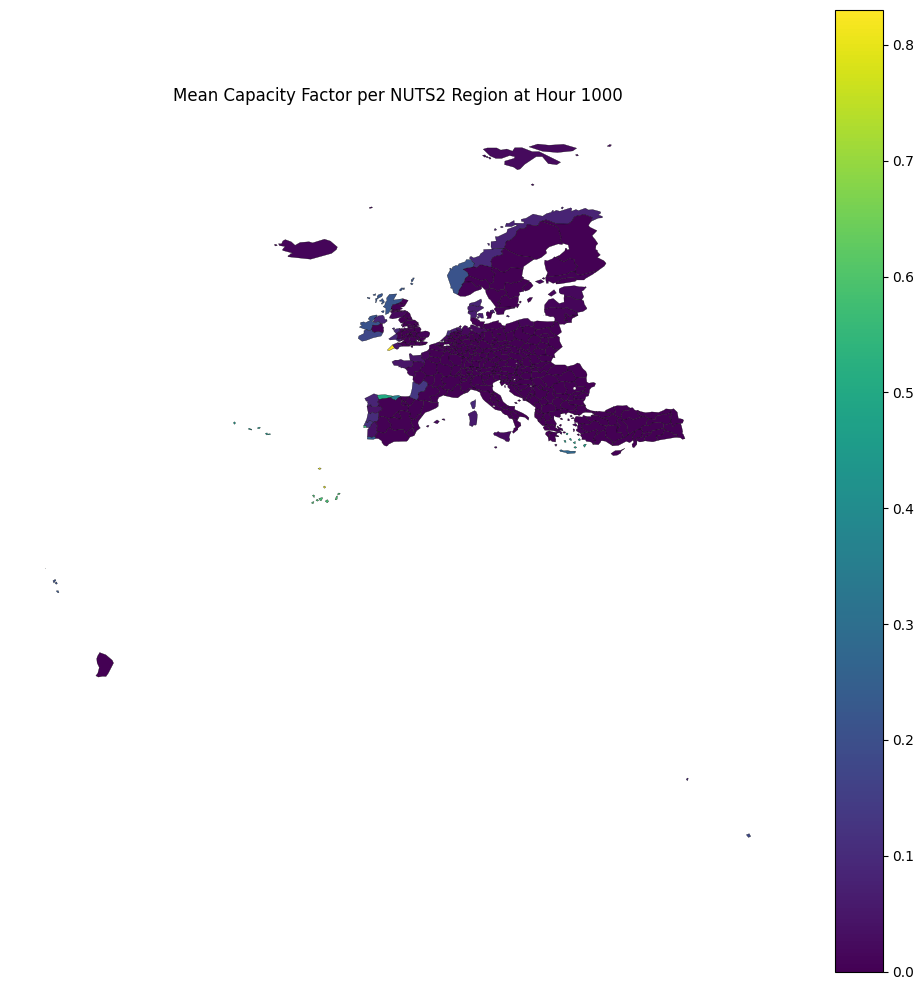

In [6]:
# Merge mean CF back into the NUTS2 geometry
nuts2_with_cf = nuts2_gdf.merge(cf_by_nuts2, on='NUTS_ID')

# Plot the result
fig, ax = plt.subplots(figsize=(10, 10))
nuts2_with_cf.plot(column='mean_cf', ax=ax, cmap='viridis', legend=True, edgecolor='black', linewidth=0.2)
ax.set_title(f'Mean Capacity Factor per NUTS2 Region at Hour {hour}')
ax.axis('off')
plt.tight_layout()
plt.show()
